## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os

# less common imports
import matplotlib.image as mpimg
from pygam import LinearGAM, GAM, s, l
from sklearn import preprocessing
from scipy import stats
from scipy import spatial
from scipy.stats import f
from sklearn.cluster import AgglomerativeClustering
import shutil
import gc
from seaborn import clustermap
import matplotlib.cm as cm

# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.6.0 anndata==0.7.4 umap==0.4.3 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.8.0


In [2]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

## **Format logTMM data from limma-voom into workable form for GAM curve fitting**

In [3]:
# Set path and read in logTMM normalized data from limma-voom output directories
# These directories can be downloaded from http://brain.listerlab.org/Major-Traj-Limma-Voom.html
dt_path = "../data/limma-voom/"
dt_fls = os.listdir( path=dt_path)

In [4]:
# read in anndata for obs
adata = sc.read_h5ad( "../data/post-gaba-wt-dev-traj.h5ad")
obs_df = adata.obs.copy()
# clean up dataframe by dropping all duplicates of batch entries
obs_df.drop_duplicates( subset='batch', keep="first", inplace=True)

In [5]:
# load log2 TMM pseudo-bulked data from limma-voom
# logTMMs.pkl was saved in 11__dev-DEGs_age-trend-fits_rate-of-change.ipynb
logTMMs = nmc.load_obj( "../data/logTMMs.pkl")

In [6]:
# example logTMM dataframe
logTMMs['Astro'].head()

,RL2103_ga22_v3,RL2107_ga24_v3,RL2121_ga34_v3,RL1777_2d_v3,RL1612_34d_v2,RL2100_86d_v3,RL2104_118d_v3,RL2108_179d_v3,RL2122_301d_v3,RL2125_422d_v3,...,RL2110_10yr_v3,RL2126_10yr_v3,RL2127_12yr_v3,RL2130_14yr_v3,RL2102_16yr_v3,RL2131_17yr_v3,RL2123_20yr_v3,RL2128_20yr_v3,RL2132_25yr_v3,RL2124_40yr_v3
RP4-669L17.10,3.262914,2.563581,5.441405,3.789194,3.777097,4.668260,3.590798,4.147364,5.336433,4.960163,...,5.278157,5.440160,5.193255,5.352841,5.165714,4.598815,5.703545,4.824757,4.666973,5.538194
HES4,8.114207,8.675959,6.533670,8.162519,7.155232,6.822653,7.475238,6.808007,2.653773,3.480646,...,6.554246,3.895045,4.002476,6.637216,6.482754,5.844978,5.066663,5.929921,6.356468,4.827944
B3GALT6,4.381164,3.205800,3.550417,3.986218,4.176051,3.571567,3.496453,3.535681,-0.718015,2.302078,...,3.185246,1.831968,1.884341,2.157840,2.090287,2.927427,1.794633,2.228402,2.401556,1.428959
SCNN1D,2.351506,1.704798,3.896255,2.709747,3.526801,4.354930,2.901563,3.650960,4.545267,3.736044,...,5.563548,4.538673,4.148996,3.750216,5.260352,4.178468,5.579543,4.981960,3.415214,4.111419
MORN1,4.216491,2.981973,4.609465,4.058063,3.990321,4.239048,3.841649,4.133640,3.582350,3.679891,...,4.704451,5.151509,4.472182,4.693571,5.305440,4.545758,4.639772,5.089552,4.363615,5.143683


In [7]:
# change column names in each logTMM to stage of batch
# will use these values as x-axis in curve fitting
plot_labels = {}
for key_itr in logTMMs.keys():
    new_cols = []
    for col_itr in logTMMs[key_itr]:
        age_itr = obs_df['stage_id'][obs_df['batch']==col_itr].values[0]
        new_cols.append( age_itr)
    plot_labels[key_itr] = [ii.split('_')[1] for ii in logTMMs[key_itr].columns]
    logTMMs[key_itr].columns = new_cols

In [8]:
logTMMs['Astro'].head()

,Fetal,Fetal,Fetal,Neonatal,Neonatal,Infancy,Infancy,Infancy,Infancy,Childhood,...,Adolescence,Adolescence,Adolescence,Adolescence,Adolescence,Adolescence,Adult,Adult,Adult,Adult
RP4-669L17.10,3.262914,2.563581,5.441405,3.789194,3.777097,4.668260,3.590798,4.147364,5.336433,4.960163,...,5.278157,5.440160,5.193255,5.352841,5.165714,4.598815,5.703545,4.824757,4.666973,5.538194
HES4,8.114207,8.675959,6.533670,8.162519,7.155232,6.822653,7.475238,6.808007,2.653773,3.480646,...,6.554246,3.895045,4.002476,6.637216,6.482754,5.844978,5.066663,5.929921,6.356468,4.827944
B3GALT6,4.381164,3.205800,3.550417,3.986218,4.176051,3.571567,3.496453,3.535681,-0.718015,2.302078,...,3.185246,1.831968,1.884341,2.157840,2.090287,2.927427,1.794633,2.228402,2.401556,1.428959
SCNN1D,2.351506,1.704798,3.896255,2.709747,3.526801,4.354930,2.901563,3.650960,4.545267,3.736044,...,5.563548,4.538673,4.148996,3.750216,5.260352,4.178468,5.579543,4.981960,3.415214,4.111419
MORN1,4.216491,2.981973,4.609465,4.058063,3.990321,4.239048,3.841649,4.133640,3.582350,3.679891,...,4.704451,5.151509,4.472182,4.693571,5.305440,4.545758,4.639772,5.089552,4.363615,5.143683


## **Fit GAM to each gene across stages**

In [9]:
# This will take a while to run
n_splines = 12
n_grid_pts = 100
stage_order = adata.uns['stage_order'].tolist()
gam_fits = {}
for key_itr, sig_df in logTMMs.items(): 
    # set x-axis for dev-traj using column values
    ax = [stage_order.index(ss) for ss in logTMMs[key_itr]]
    # dataframe to hold fits
    fits_df = pd.DataFrame( np.zeros((sig_df.shape[0],n_grid_pts), dtype=float), index=sig_df.index)
    for gene_itr in sig_df.index:
        # y-axis gene values
        ay = sig_df.loc[gene_itr,:].values
        # fit GAM
        gam = LinearGAM( s( 0, lam=0.6, n_splines=n_splines), fit_intercept=False).fit( ax, ay)
        axx = gam.generate_X_grid( term=0, n=n_grid_pts)
        yyy = gam.predict( X=axx)
        fits_df.loc[gene_itr,:] = yyy
        
    gam_fits[key_itr] = fits_df  
    print( key_itr)  

Astro
ID2
L2-3_CUX2
L4_RORB
L5-6_THEMIS
L5-6_TLE4
LAMP5_NOS1
Micro
Oligo
OPC
PV
PV_SCUBE3
SST
VIP


In [10]:
# save to use in future analysis
nmc.save_obj( gam_fits, f"../data/STAGE_gam_fits_12_grid{n_grid_pts}.pkl")

## **Plot trend fits**

In [11]:
shape_dict = {}
for ii in adata.uns['major_clust_plot_order']:
    if ii=='Poor-Quality':
        continue
    if ii in ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS','L5-6_TLE4']:
        shape_dict[ii] = 'o'
    elif ii in ['VIP', 'ID2', 'LAMP5_NOS1']:
        shape_dict[ii] = 'v'
    elif ii in ['SST', 'PV', 'PV_SCUBE3']:
        shape_dict[ii] = '^'
    else:
        shape_dict[ii] = 'P'

In [12]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.edgecolor'] = 'black'
plt.rcParams["legend.markerscale"] = 3.5
plt.rc('font', size=14) 

In [13]:
def plot_trend( cluster, gene, n_grid_pts=n_grid_pts):
    if isinstance( gene, int):
        gene = trend_df.index.values[gene]
    plt.figure( figsize=(10,4))
    # plot trend fit      
    trend = gam_fits[cluster].loc[gene]
    plt.plot( range( len(trend)), trend, 
              color=adata.uns['major_clust_colors_dict'][cluster],
              linewidth=4.0)
    # plot TMM bulk points
    scat_df = logTMMs[cluster]
    scat_x = [stage_order.index(ss) for ss in scat_df.columns.values]
    num_stages = len(np.unique(scat_df.columns))
    scat_x = np.array( scat_x) * (n_grid_pts/(num_stages-1))
    scat = scat_df.loc[gene,:]
    plt.scatter( scat_x, scat, alpha=0.5,
                 c=adata.uns['major_clust_colors_dict'][cluster],
                 marker=shape_dict[cluster])
    # plot attributes
    ticks = np.linspace(0, n_grid_pts, num_stages)
    plt.xticks( ticks=ticks, labels=stage_order, rotation=90);
    plt.title( f"{cluster} - {gene}", fontsize=18, style='italic', weight='bold');
    plt.ylabel( 'Log2 CPM');
    plt.show()
    return

def plot_trends( clusters, gene, gam_fits=gam_fits, logTMMs=logTMMs, stage_order=stage_order, scale=False):
    # set up plot figure
    plt.figure( figsize=(10,4))
    # plot parameters
    alpha = 0.9
    num_stages = len(stage_order)
    # list of possible clusters
    gam_clusters = list( gam_fits.keys())
    # loop through clusters
    for clust_itr in clusters:
        # make sure cluster is in dataframe
        if( clust_itr not in gam_clusters):
            print( f"{clust_itr} cluster name not found, the following are valid names:\n {gam_clusters}")
            continue
        # gam dataframe of fits for cluster
        gam_df = gam_fits[clust_itr]
        # determine if devDEG or not, then plot trend and scatter
        if gene in gam_df.index:
            # plot trend fit      
            trend = gam_df.loc[gene]
            # scale 0 to 1 if requested
            if scale:
                min_max_scaler = preprocessing.MinMaxScaler()
                trend = min_max_scaler.fit_transform( trend.values.reshape(-1, 1))
            plt.plot( np.arange( 0.5, len(trend)+0.5), trend, 
                      color=adata.uns['major_clust_colors_dict'][clust_itr],
                      linewidth=4.0, label=clust_itr)
    # plot attributes
    plt.legend( bbox_to_anchor=(1.15, 0.45), loc="center");
    ticks = np.linspace(0, n_grid_pts, num_stages)
    plt.xticks( ticks=ticks, labels=stage_order, rotation=90);
    plt.title( gene, fontsize=18, style='italic', weight='bold')
    plt.ylabel( 'Log2 CPM')
    plt.show()
    return

### Only devDEGs will be plotted. If a requested trajectory and gene combination does not return a trend plot, the requested gene was not found to be significantly dynamic over ages/stages sampled for that trajectory. 

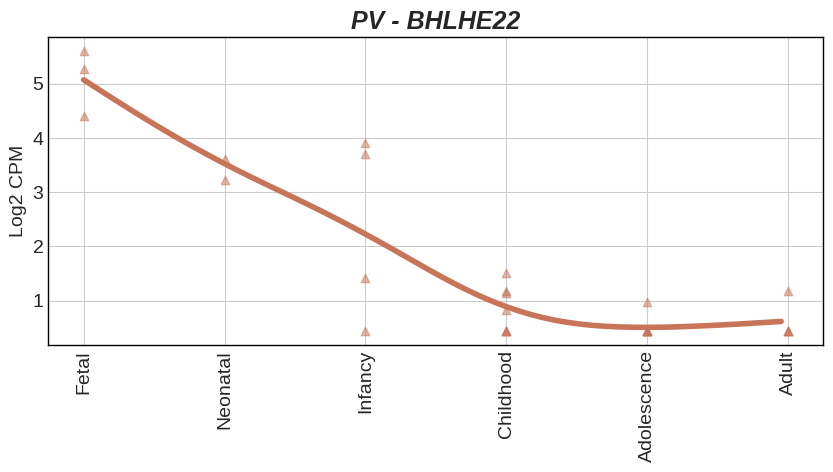

In [14]:
# plot single devDEG trend with log2 CPM data points included
plot_trend( cluster="PV", gene="BHLHE22")

In [15]:
# set lists of clusters to plot
pns = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4']
neurons = ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4',
           'VIP', 'ID2', 'LAMP5_NOS1', 
           'SST', 'PV', 'PV_SCUBE3']
all_clusts = np.append( neurons, ['Astro', 'OPC', 'Oligo']) #, 'Micro'])

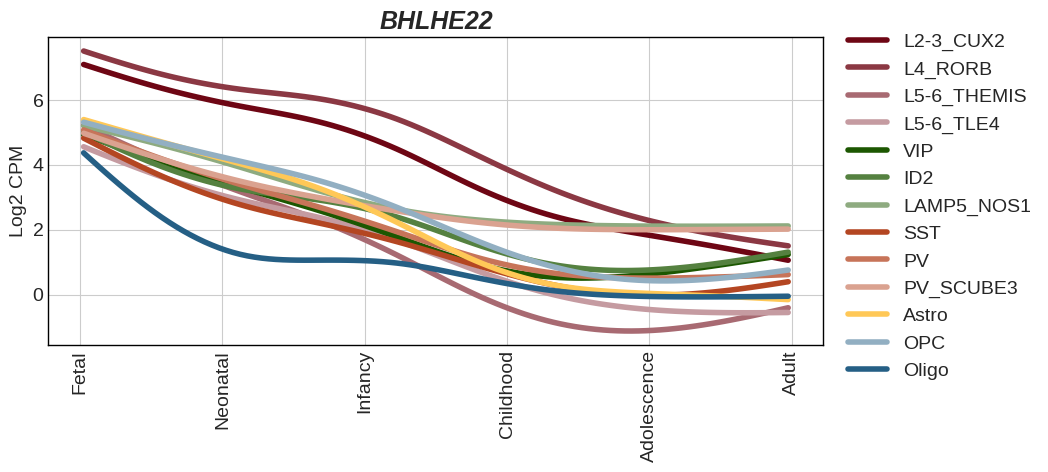

In [16]:
# plot multiple devDEG trends on same plot, clusters should be in a list
plot_trends( clusters=all_clusts, gene="BHLHE22")

### Can also scale trends 0 to 1

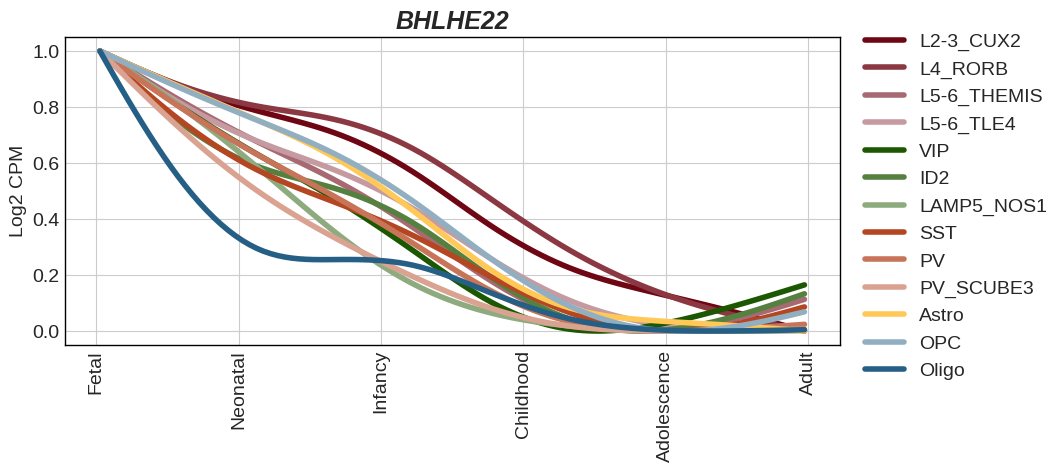

In [17]:
# plot multiple devDEG trends on same plot, clusters should be in a list
plot_trends( clusters=all_clusts, gene="BHLHE22", scale=True)